In [1]:
import numpy as np # linear algebra
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
from sklearn import linear_model,svm, metrics
import winsound
%matplotlib inline

Unpickle the data

In [2]:
folder = 'D:/Libraries/Documents/Tensorflow/tensorflow/Statoil/'
with open(folder+'labeled_data.pkl','rb') as f:
    data = pickle.load(f)

b1train= data['b1train']
b1valid= data['b1valid']
b1test= data['b1test']
b2train= data['b2train']
b2valid= data['b2valid']
b2test= data['b2test']
anglestrain= data['anglestrain']
anglesvalid= data['anglesvalid']
anglestest= data['anglestest']
labelstrain= data['labelstrain']
labelsvalid= data['labelsvalid']
labelstest= data['labelstest']
idstrain= data['idstrain']
idsvalid= data['idsvalid']
idstest= data['idstest']

## Let's reshape the data back into images, and verify that the data still looks okay

The convolutional network will use the data in unflattened form. Just displaying the images to make sure they were unflattened correctly

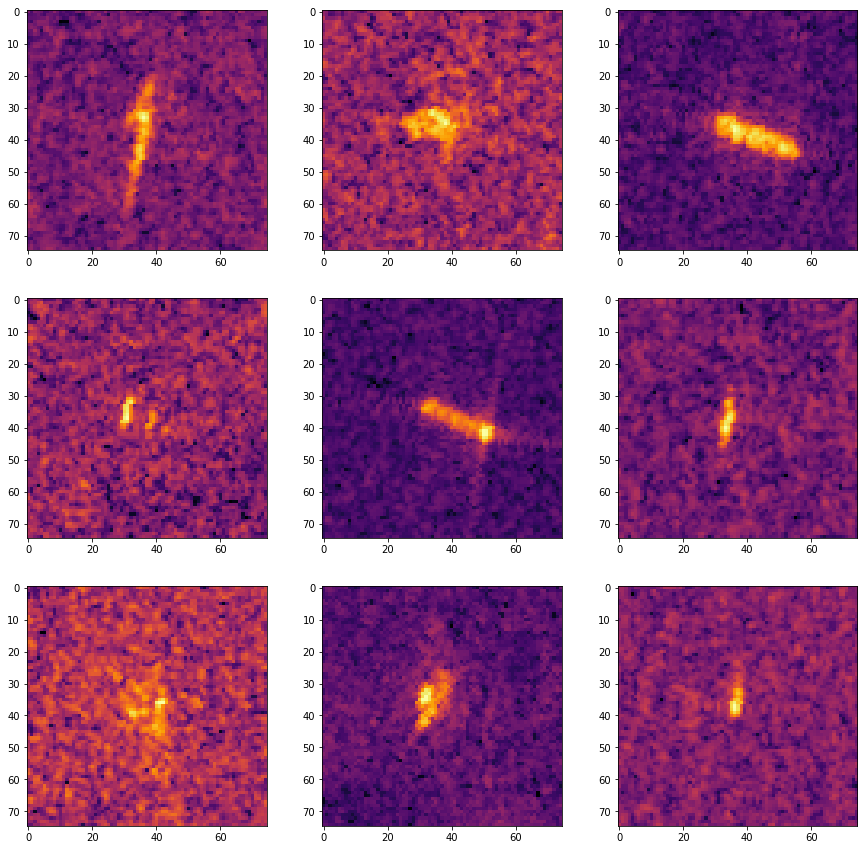

In [3]:
img_size = 75
def reshape(flattened_image_set,img_size):
  return np.reshape(flattened_image_set, [flattened_image_set.shape[0],img_size,img_size])
b1train = reshape(b1train, img_size)
b2train = reshape(b2train, img_size)
b1valid = reshape(b1valid, img_size)
b2valid = reshape(b2valid, img_size)
b1test = reshape(b1test,img_size)
b2test = reshape(b2test,img_size)

fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(b1train[i]),(75,75))
    ax.imshow(arr,cmap='inferno')
plt.show()

A convnet can also use both bands together as 2 channels. So we create our final data sets to input into our model by putting both bands into 1 array.

In [4]:
num_examples = b1train.shape[0]#1404
Xtrain = np.zeros(shape=[num_examples,img_size,img_size,2])#2 bands
Xtrain[:,:,:,0]=b1train
Xtrain[:,:,:,1]=b2train
num_valid = b1valid.shape[0]#100
Xvalid = np.zeros(shape=[num_valid,img_size,img_size,2])
Xvalid[:,:,:,0]=b1valid
Xvalid[:,:,:,1]=b2valid
num_test = b1test.shape[0]#100
Xtest = np.zeros(shape = [num_test,img_size,img_size,2])
Xtest[:,:,:,0]=b1test
Xtest[:,:,:,1]=b2test

There is a bug with tf.layer.conv2d for float64s so I will stick with float32 precision for now

In [5]:
Xtrain = np.float32(Xtrain)
Xvalid = np.float32(Xvalid)
Xtest = np.float32(Xtest)

In [6]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Converting our labels to one-hot encodings for the cross entropy function

In [7]:
print(labelstest[0:5])
onehot_test = np.ndarray(shape=[labelstest.shape[0],2])
onehot_test[:,0]=(labelstest == 0)
onehot_test[:,1]=(labelstest == 1)
print(onehot_test[0:5,:])

[0 1 1 0 1]
[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]]


In [8]:
print(labelsvalid[0:5])
onehot_valid = np.ndarray(shape=[labelsvalid.shape[0],2])
onehot_valid[:,0]=(labelsvalid == 0)
onehot_valid[:,1]=(labelsvalid == 1)
print(onehot_valid[0:5,:])

[1 1 0 1 0]
[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]]


In [9]:
print(labelstrain[0:5])
onehot_train=np.ndarray(shape=[labelstrain.shape[0],2])
onehot_train[:,0]=(labelstrain == 0)
onehot_train[:,1]=(labelstrain == 1)
print(onehot_train[0:5,:])

[1 1 0 0 0]
[[ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


## Let's try a convolutional network with a basic structure. 
Conv --> pooling --> conv --> pooling --> FC --> FC, using Relu activations

In [10]:
num_labels = 2
depth = 16
num_hidden = 64
num_channels=2
patch_size=5
batch_size=64
learning_rate = 0.0005


graph = tf.Graph()
with graph.as_default():
  
  #inputs
  tf_input_X = tf.placeholder(shape=[batch_size, img_size, img_size, 2], dtype = tf.float32)
  tf_input_y = tf.placeholder(shape=[batch_size, num_labels], dtype= tf.float32)
  
  #constants
  tf_valid_dataset = tf.constant(Xvalid)
  tf_test_dataset = tf.constant(Xtest)
  
  #convolutional layers
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))#why is this initialized to 1 and the last one to 0?
  layer3_weights = tf.Variable(tf.truncated_normal(
      [19 * 19 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')#stride of 1
    hidden = tf.nn.relu(conv + layer1_biases)
    pooled = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    conv = tf.nn.conv2d(pooled, layer2_weights, [1, 1, 1, 1], padding='SAME')#stride of 1
    hidden = tf.nn.relu(conv + layer2_biases)
    pooled = tf.nn.max_pool(hidden, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    shape = pooled.get_shape().as_list()
    reshape = tf.reshape(pooled, [shape[0], shape[1] * shape[2] * shape[3]])#flatten the image for the FC layers
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_input_X)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_input_y, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))
  
  

In [11]:
num_steps = 10001
test_preds = 0

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (labelstrain.shape[0] - batch_size)
    batch_data = Xtrain[offset:(offset + batch_size), :, :, :]
    batch_labels = onehot_train[offset:(offset + batch_size), :]
    feed_dict = {tf_input_X : batch_data, tf_input_y : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), onehot_valid))
  test_preds = test_prediction.eval()
  print('Test accuracy: %.1f%%' % accuracy(test_preds, onehot_test))


Initialized
Minibatch loss at step 0: 6.658782
Minibatch accuracy: 60.9%
Validation accuracy: 48.0%
Minibatch loss at step 500: 0.549166
Minibatch accuracy: 71.9%
Validation accuracy: 66.0%
Minibatch loss at step 1000: 0.436418
Minibatch accuracy: 75.0%
Validation accuracy: 71.0%
Minibatch loss at step 1500: 0.430458
Minibatch accuracy: 79.7%
Validation accuracy: 75.0%
Minibatch loss at step 2000: 0.388024
Minibatch accuracy: 82.8%
Validation accuracy: 80.0%
Minibatch loss at step 2500: 0.223986
Minibatch accuracy: 92.2%
Validation accuracy: 82.0%
Minibatch loss at step 3000: 0.345371
Minibatch accuracy: 85.9%
Validation accuracy: 79.0%
Minibatch loss at step 3500: 0.233013
Minibatch accuracy: 92.2%
Validation accuracy: 83.0%
Minibatch loss at step 4000: 0.182559
Minibatch accuracy: 92.2%
Validation accuracy: 81.0%
Minibatch loss at step 4500: 0.187927
Minibatch accuracy: 89.1%
Validation accuracy: 84.0%
Minibatch loss at step 5000: 0.276173
Minibatch accuracy: 90.6%
Validation accurac

We can see that the network is clearly overfitting. We need to add dropout. Also learning rate decay may be an interesting option since a higher learning rate caused divergence and the lower ones are taking long to converge.